# 03. PyTorch Computer Vision

Computer vision is the art of teaching a computer to see.

**Resources:**
* Book version of this notebook - https://www.learnpytorch.io/03_pytorch_computer_vision/

##  What we're going to cover
* Getting a vision dataset to work with using `torchvision.datasets`.
* Architecture of a convolutional neural network (CNN) with PyTorch.
* An end-to-end multi-class image classification problem.
* Steps in modelling with CNNs with PyTorch.
    * Creating a CNN model with PyTorch.
    * Picking a loss and optimizer.
    * Training a model.
    * Evaluating a model.

## 0. Computer vision libraries in PyTorch

* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [160]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.4.0
0.19.0


## 1. Getting a dataset 

The dataset we'll be using in FashionMNIST from torchvision.datasets - https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html

In [161]:
# Setup training data
train_data = datasets.FashionMNIST(
    root='data', # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)



In [162]:
len(train_data), len(test_data)

(60000, 10000)

In [163]:
# See the first training example
image, label = train_data[0]
image, label 

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [164]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [165]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [166]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [167]:
# Check the shape of our image
print(f'Image shape: {image.shape} -> [color_channels, height, width]')
print(f'Image label: {class_names[label]}')

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### 1.2 Visualizing our data

Text(0.5, 1.0, '9')

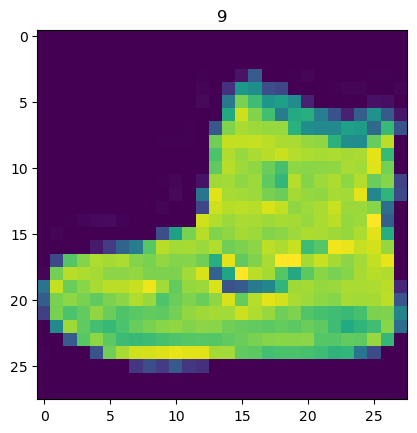

In [168]:
plt.imshow(image.squeeze())
plt.title(label)

(-0.5, 27.5, 27.5, -0.5)

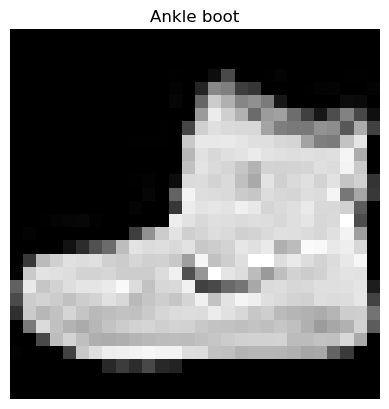

In [169]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

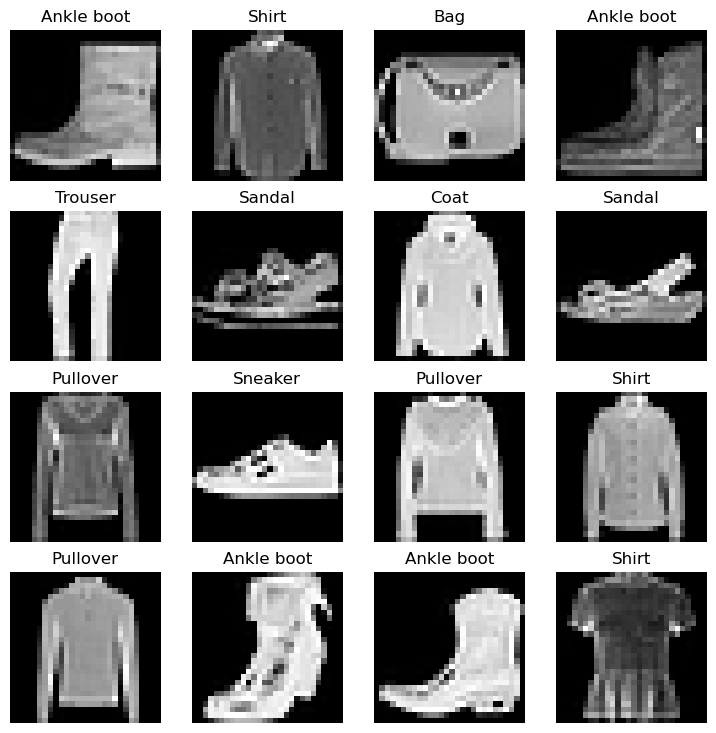

In [170]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

Do you think these items of clothing (images) could be modelled with pure linear lines? Or do you think we'll need non-linearities?

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to uptade its gradients per epoch.

For more on mini-batches, see here: https://www.youtube.com/watch?v=4qJaSmvhxi8

In [171]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
batch_size = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False
)

In [172]:
# Let's check out what we've created
print(f'DataLoaders: {train_dataloader, test_dataloader}')
print(f'Length of train_dataloader: {len(train_dataloader)} batches of {batch_size}...')
print(f'Length of test_dataloader: {len(test_dataloader)} batches of {batch_size}...')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x174b99730>, <torch.utils.data.dataloader.DataLoader object at 0x172c27d40>)
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [173]:
60000/32, 10000/32

(1875.0, 312.5)

In [174]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


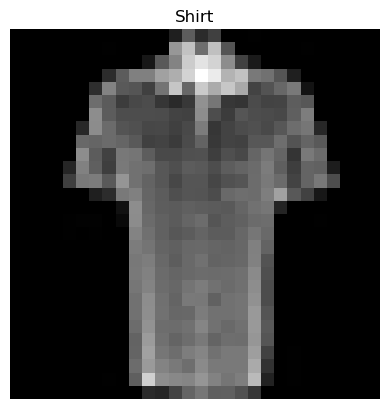

In [175]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f'Image size: {image.shape}')
print(f'Label: {label}, label size: {label.shape}')

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [176]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Got a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f'Shape before flattening: {x.shape} -> [color_channel, height, width]')
print(f'Shape after flattening: {output.shape} -> [color_channel, height * width]')

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channel, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channel, height * width]


In [177]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(
        self,
        input_shape:int,
        hidden_units:int,
        output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=input_shape,
                out_features=hidden_units
            ),
            nn.Linear(
                in_features=hidden_units,
                out_features=output_shape
            )
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [178]:
torch.manual_seed(42)

# Setup mdoel with input parameters

model_0 = FashionMNISTModelV0(
    input_shape=784, # this is 28*28
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(class_names) # one for every class    
).to('cpu')
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [179]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [180]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation matric - since we're working on a classification problem, let's use accuracy as our evaluation metric

In [181]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists, skipping download...')
else:
    print('Downloading helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

helper_functions.py already exists, skipping download...


In [182]:
# Import accuracy matric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values, etc)
2. How fast it runs

In [183]:
from timeit import default_timer as timer
def print_train_time(
    start:float,
    end:float,
    device:torch.device=None):
    '''
    Prints difference between start and end time.
    '''
    total_time = (end - start)
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

In [184]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device='cpu')

Train time on cpu: 0.000 seconds


1.2208009138703346e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all(for fun).

In [185]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n------')
    # Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Print out what's happening
        if (batch % 400) == 0:
            print(f'Looked at {batch * len(X)}\{len(train_dataloader.dataset)} samples.')
            
    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)
    
    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)
            
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test)
            
            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
        
        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)
        
        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)
        
    # Print out what's happening
    print(f'\n Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}')
    
# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_on_cpu,
    end=train_time_end_on_cpu,
    device=str(next(model_0.parameters()).device)
)
        

<string>:38: SyntaxWarning: invalid escape sequence '\{'
<>:38: SyntaxWarning: invalid escape sequence '\{'
<string>:38: SyntaxWarning: invalid escape sequence '\{'
<>:38: SyntaxWarning: invalid escape sequence '\{'
/var/folders/sj/rsk1sbf92sd25h1n5vr0711c0000gn/T/ipykernel_53852/1111560246.py:38: SyntaxWarning: invalid escape sequence '\{'
  print(f'Looked at {batch * len(X)}\{len(train_dataloader.dataset)} samples.')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0\60000 samples.
Looked at 12800\60000 samples.
Looked at 25600\60000 samples.
Looked at 38400\60000 samples.
Looked at 51200\60000 samples.

 Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387
Epoch: 1
------
Looked at 0\60000 samples.
Looked at 12800\60000 samples.
Looked at 25600\60000 samples.
Looked at 38400\60000 samples.
Looked at 51200\60000 samples.

 Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969
Epoch: 2
------
Looked at 0\60000 samples.
Looked at 12800\60000 samples.
Looked at 25600\60000 samples.
Looked at 38400\60000 samples.
Looked at 51200\60000 samples.

 Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 7.404 seconds


## 4. Make predictions and get Model 0 results

In [186]:
torch.manual_seed(42)
def eval_model(
    model: torch.nn.Module,
    data_loader:torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn, 
    device=device):
    '''
    Returns a dictionary containing the results of model predicting on data_loader.
    '''
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)
            
            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(
                y_true=y,
                y_pred=y_pred.argmax(dim=1)
            )
            
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    ret_dict = {
        'model_name': model.__class__.__name__, # only works when model was created with a class
        'model_loss': loss.item(),
        'model_acc': acc
    }
    return ret_dict

# Calculate model 0 results on test dataset
model_0_results = eval_model(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code (for using a GPU if there is one)

In [187]:
# Setup device-agnostic code
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 6. Model 1: Building a better model with non-linearity

We learned about the power of non-linearity in notebook 02 - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb

In [188]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(
        self,
        input_shape:int,
        hidden_units:int,
        output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into a single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [189]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(
    input_shape=784, # this is the output of the flatten after our 28*28 image goes in
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

### 6.1 Setup loss, optimizer and evaluation matrics

In [190]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
optimizer = torch.optim.SGD(
    model_1.parameters(), # tries to update our model's parameters to reduce the loss
    lr=0.1
)

### 6.2 Functionizing training and evaluation/testing loops

Let's create a function for:
* training loo - `train_step()`
* testing loop - `test_step()`

In [191]:
def train_step(
    model:torch.nn.Module,
    data_loader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device:torch.device=device):
    '''
    Performs a training with model trying to learn on data_loader
    '''
    train_loss, train_acc = 0, 0
    
    # Put model into training mode
    model.train()
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()

    # Divide total train loss and acc by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%')


def test_step(
    model:torch.nn.Module,
    data_loader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    accuracy_fn,
    device:torch.device=device):
    '''
    Performs a testing loop step on model going over data_loader
    '''
    test_loss, test_acc = 0, 0
    
    # Put the model in eval mode
    model.eval()
    
    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send the data to the target device
            X, y = X.to(device), y.to(device)
             
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss/acc
            # print(test_pred.shape)
            # print(tes_pred.shape)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n')

In [192]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as Timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n----------')
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
    test_step(
        model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
train_time_end_on_gpu = timer()

total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1
----------
Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%

Epoch: 2
----------
Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%

Train time on cpu: 7.431 seconds


**Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.

Why is this??

1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU.
2. The hardware you're using has a better CPU in terms compute capability than the GPU.

For more on how to make your models computer faster, see here: https://horace.io/brrr_intro.html

In [193]:
# Get model_1 results dictionary
model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008368492126,
 'model_acc': 75.01996805111821}

In [194]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Model 2: Building a Convolutional Neural Network (CNN)
CNN's are also known ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

To find out what's happening inside a CNN, see this website: https://poloclub.github.io/cnn-explainer/


In [195]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    '''
    Model architecture that replicates the TinyVGG model from CNN explainer website
    '''
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            # Create a conv layer - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1, 
                padding=1
                ), # values we can set ourselves in our NN's are called hyperparameters
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1, 
                padding=1
                ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1, 
                padding=1
                ), # values we can set ourselves in our NN's are called hyperparameters
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1, 
                padding=1
                ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=(hidden_units * 7 * 7), # there's a trick to calculating this... 
                out_features=output_shape
                )
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        # print(f'Output shape of conv_block_1: {x.shape}')
        x = self.conv_block_2(x)
        # print(f'Output shape of conv_block_2: {x.shape}')
        x = self.classifier(x)
        # print(f'Output shape of classifier: {x.shape}')
        return x

In [196]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

In [197]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [198]:
# Pass image through model
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], grad_fn=<AddmmBackward0>)

### 7.1 Stepping through `nn.Conv2d()`

See the documentation for `nn.Conv2d()` here - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [199]:
torch.manual_seed(42)

# Create a batch of images
images = torch.rand(size=(32, 3, 64, 64))
test_image = images[0]

print(f'Image batch shape: {images.shape}')
print(f'Single image shape: {test_image.shape}')
print(f'Test image:\n: {test_image}')

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
: tensor([[[0.8823, 0.9150, 0.3829,  ..., 0.1587, 0.6542, 0.3278],
         [0.6532, 0.3958, 0.9147,  ..., 0.2083, 0.3289, 0.1054],
         [0.9192, 0.4008, 0.9302,  ..., 0.5535, 0.4117, 0.3510],
         ...,
         [0.1457, 0.1499, 0.3298,  ..., 0.9624, 0.6400, 0.7409],
         [0.1709, 0.5797, 0.6340,  ..., 0.6885, 0.2405, 0.5956],
         [0.9199, 0.1247, 0.3573,  ..., 0.6752, 0.2058, 0.5027]],

        [[0.1458, 0.9024, 0.9217,  ..., 0.1868, 0.6352, 0.8431],
         [0.9549, 0.4435, 0.6924,  ..., 0.1168, 0.7160, 0.5462],
         [0.1616, 0.1054, 0.8614,  ..., 0.4531, 0.4736, 0.9448],
         ...,
         [0.4309, 0.3986, 0.1907,  ..., 0.9444, 0.2848, 0.3776],
         [0.7948, 0.6855, 0.1009,  ..., 0.6147, 0.7747, 0.2323],
         [0.5840, 0.9795, 0.3277,  ..., 0.3549, 0.1263, 0.1280]],

        [[0.5027, 0.4195, 0.8893,  ..., 0.3084, 0.1567, 0.7860],
         [0.7310, 

In [200]:
torch.manual_seed(42)
# Create a single conv2d layer
conv_layer = nn.Conv2d(
    in_channels=3,  # number of channels of the image
    out_channels=10,
    kernel_size=3, 
    stride=1,
    padding=1
    )

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
conv_output, conv_output.shape

(tensor([[[ 0.3723,  0.4130,  0.4932,  ...,  0.2233,  0.2555,  0.1500],
          [ 0.4561,  0.6552,  0.5381,  ...,  0.1734,  0.2343,  0.5169],
          [ 0.5605,  0.4011,  0.2772,  ...,  0.3547,  0.4406,  0.1736],
          ...,
          [ 0.4173,  0.4143,  0.6770,  ...,  0.3320,  0.5752,  0.2145],
          [ 0.4520,  0.1725,  0.3980,  ...,  0.5133,  0.3385,  0.4232],
          [ 0.4202,  0.4273,  0.4284,  ...,  0.2919,  0.4275,  0.1534]],
 
         [[-0.1190, -0.1214, -0.0371,  ...,  0.0978, -0.3614, -0.1220],
          [-0.5015,  0.0954, -0.0688,  ..., -0.4996, -0.0184,  0.2113],
          [-0.0653, -0.0188, -0.1703,  ..., -0.0339,  0.1632, -0.0642],
          ...,
          [ 0.0369, -0.1508, -0.1934,  ..., -0.0989,  0.2556, -0.2318],
          [ 0.1521,  0.0447,  0.1020,  ..., -0.0682, -0.2266, -0.2989],
          [-0.4602, -0.1780, -0.4226,  ..., -0.2864, -0.0762, -0.1898]],
 
         [[ 0.1305,  0.1485, -0.1376,  ..., -0.0726,  0.3210,  0.1206],
          [-0.0889,  0.0098,

### 7.2 Stepping through `nn.MaxPool2d()`
See the documentation for `nn.MaxPool2d()` here - https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [201]:
# Print  out original image shape
print(f'Test image original shape: {test_image.shape}')

# Create a sample nn.MaxPool2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image)
print(f'Shape after going through conv_layer(): {test_image_through_conv.shape}')

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f'Shape after going through conv_layer() and max_pool_layer: {test_image_through_conv_and_max_pool.shape}')

Test image original shape: torch.Size([3, 64, 64])
Shape after going through conv_layer(): torch.Size([10, 64, 64])
Shape after going through conv_layer() and max_pool_layer: torch.Size([10, 32, 32])


In [202]:
torch.manual_seed(42)

# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.rand(size=(1, 1, 2, 2))
print(f'\nRandom tensor:\n{random_tensor}')
print(f'Random tensor shape: {random_tensor.shape}')

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensorr through the max pool
max_pool_tensor = max_pool_layer(random_tensor)
print(f'\nMax pool tensor:\n {max_pool_tensor}')
print(f'Max pool tensor shappe: {max_pool_tensor.shape}')


Random tensor:
tensor([[[[0.8823, 0.9150],
          [0.3829, 0.9593]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
 tensor([[[[0.9593]]]])
Max pool tensor shappe: torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for `model_2`

In [203]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model_2.parameters(),
    lr=0.1
)

### 7.4 Training and testing `model_2` using our training and test functions

In [204]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------')
    train_step(
        model=model_2,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(
        model=model_2,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device   
    )
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(
    start=train_time_start_model_2,
    end=train_time_end_model_2,
    device=device
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.58826 | Train acc: 78.61%
Test loss: 0.36350 | Test acc: 86.91%

Epoch: 1
-------
Train loss: 0.36054 | Train acc: 86.99%
Test loss: 0.35078 | Test acc: 87.80%

Epoch: 2
-------
Train loss: 0.32510 | Train acc: 88.28%
Test loss: 0.31897 | Test acc: 88.50%

Train time on cpu: 111.001 seconds


In [205]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
   data_loader=test_dataloader,
   loss_fn=loss_fn,
   accuracy_fn=accuracy_fn,
   device=device 
)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3438083827495575,
 'model_acc': 87.8694089456869}

In [206]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 8. Compare model results and training time

In [207]:
import pandas as pd
compare_results = pd.DataFrame(
    [
        model_0_results,
        model_1_results,
        model_2_results
    ]
)
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.343808,87.869409


In [208]:
# Add training time to results comparison
compare_results['training_time'] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,7.403623
1,FashionMNISTModelV1,0.685001,75.019968,7.431440
2,FashionMNISTModelV2,0.343808,87.869409,111.001293


Text(0, 0.5, 'model')

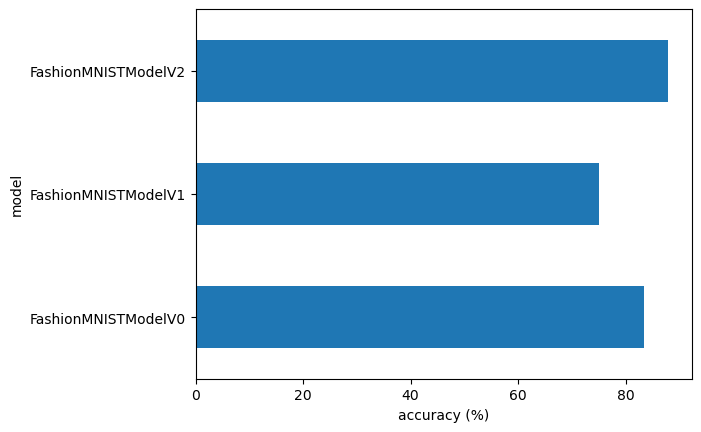

In [209]:
# Visualize our model results
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy (%)')
plt.ylabel('model')

## 9. Make and evaluate random predictions with best model

In [211]:
def make_predictions(
    model:torch.nn.Module,
    data:list,
    device:torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the same (add a batch dimension and pass to taget device)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # Forward pass (model outputs raw logits)
            pred_logits = model(sample)
            
            # Get prediction probability (logits -> prediction probability)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            
            # Get pred prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [212]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

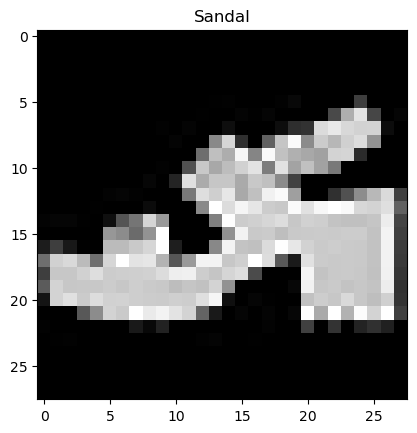

In [214]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])

In [215]:
# Make predictions
pred_probs = make_predictions(
    model=model_2,
    data=test_samples
)

# View first two prediction probabities
pred_probs[:2]

tensor([[1.7876e-07, 7.3868e-08, 4.4488e-08, 5.6478e-08, 8.9557e-09, 9.9867e-01,
         1.1854e-07, 9.1861e-05, 6.2480e-06, 1.2309e-03],
        [9.4069e-03, 9.1837e-01, 4.5844e-05, 5.9332e-02, 2.3044e-03, 5.8913e-06,
         9.5639e-03, 3.3314e-04, 5.5529e-04, 8.1117e-05]])

In [216]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1])

In [217]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

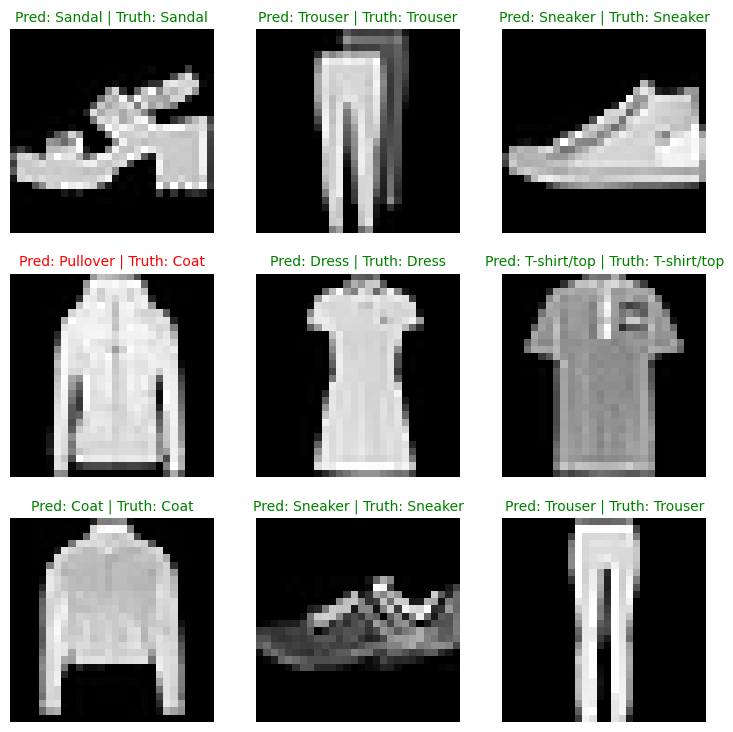

In [219]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, (i + 1))
    
    # Plot the target image
    plt.imshow(sample.squeeze(), cmap='gray')
    
    # Find the prediction (in text form, e.g 'Sandal')
    pred_label = class_names[pred_classes[i]]
    
    # Get truth label (in text form)
    truth_label = class_names[test_labels[i]]
    
    # Create a title for the plot
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'
    
    # Check for equality between pred and truth and change color of the tile text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g') # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c='r')
    
    plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluating your classification models visually: https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix() - https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

In [222]:
# Import tqdm.auto
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making predictions...'):
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_2(X)
        # Turn predictions from logits -> prediction probabilities -> prediction labels
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        # Put prediction on CPU for evaluation
        y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [223]:
len(y_pred_tensor)

10000

In [235]:
# See if required packages are installed and if not, install them...
try:
    import torchmetrics, mlxtend
    print(f'mlxtend version: {mlxtend.__version__}')
    assert int(mlxtend.__version__.split('.')[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
    !pip install  torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f'mlxtend version: {mlxtend.__version__}')

mlxtend version: 0.23.1


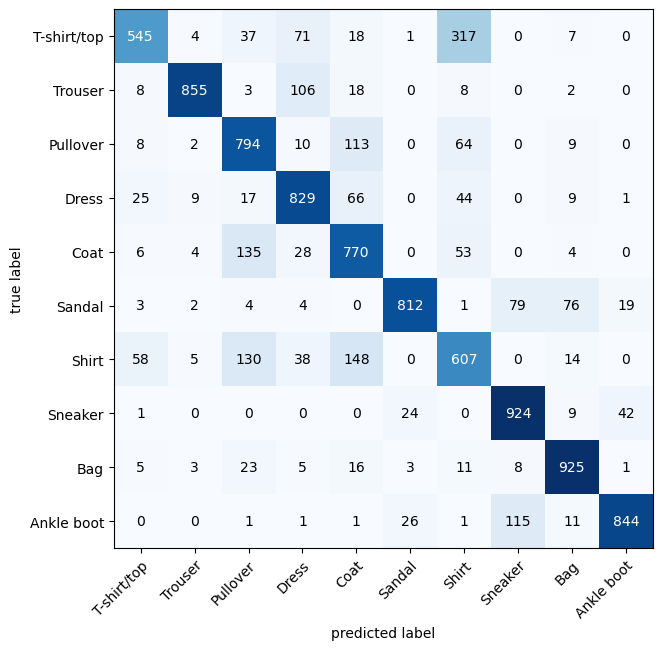

In [238]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib like working with numpy
    class_names=class_names,
    figsize=(10, 7)
)

## 11. Save and load best performing model

In [239]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(
    parents=True,
    exist_ok=True
)

# Create model save
MODEL_NAME = '03__pytorch_computer_vision_model_2.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(
    obj=model_2.state_dict(),
    f=MODEL_SAVE_PATH
)

Saving model to: models/03__pytorch_computer_vision_model_2.pth


In [240]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
)

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

/var/folders/sj/rsk1sbf92sd25h1n5vr0711c0000gn/T/ipykernel_53852/28082262.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MO

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [241]:
# Evaluate loaded model
torch.manual_seed(42)
loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3438083827495575,
 'model_acc': 87.8694089456869}

In [242]:
# Check if model results are close to each other
torch.isclose(
    torch.tensor(model_2_results['model_loss']),
    torch.tensor(loaded_model_2_results['model_loss']),
     atol=1e-02  
)

tensor(True)

## Exercises

* https://www.learnpytorch.io/03_pytorch_computer_vision/#exercises

### 1. What are 3 areas in industry where computer vision is currently being used?

### 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

### 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. Note: there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

### 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button and see what happens in each layer of a CNN as your image passes through it.

### 5. Load the [torchvision.datasets.MNIST()](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

### 6. Visualize at least 5 different samples of the MNIST training dataset.

### 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

### 8. Recreate `model_2` used in this notebook (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset.

### 9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.

### 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

### 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

### 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

### 13. Use a model similar to the trained model_2 from this notebook to make predictions on the test [torchvision.datasets.MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) dataset.

* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?